In [1]:
from src import *

In [22]:
from moviepy.editor import ImageSequenceClip


def savevid360(fig, ax, nbframes, filename="test.gif"):
    """
    Visualize the plot in 3d while rotating
    """
    ang = np.linspace(0, 360, nbframes)
    for k in range(nbframes):
        ax.view_init(elev=0, azim=ang[k])
        fig.savefig(f"/tmp/tmp{k}.png")

    images = []
    for k in range(nbframes):
        images.append(cv2.imread(f"/tmp/tmp{k}.png"))

    clip = ImageSequenceClip(list(images), fps=10)
    clip.write_gif(filename, fps=10)

In [2]:
def visualize_braingraph(
    signal,
    A,
    coords,
    figsize=(5, 5),
    axview=(0, 0),
    phasegrain=12,
    cmap="bwr",
    nscale=100,
    hlv=0.85,
):
    """
    Visualizing braingraphs and associated signals in MNI
    """
    slocation = deepcopy(coords)
    # slocation = deepcopy(clean)
    nodes = {"x": [], "y": [], "z": [], "signal": [], "phase": []}
    edges = {"i": [], "j": [], "weight": []}

    scaled_signal = signal / np.abs(signal).mean()
    grain = np.linspace(0, np.pi, phasegrain)
    p = plt.get_cmap(cmap)
    # populate nodes
    for sidx, s in enumerate(slocation):
        nodes["x"].append(s[0])
        nodes["y"].append(s[1])
        nodes["z"].append(s[2])

        angleencode = np.where((np.angle(signal[sidx]) - grain) <= 0)[0][0]
        nodes["phase"].append(p(angleencode / (phasegrain - 1)))
        nodes["signal"].append(np.abs(scaled_signal[sidx]))

    nodes = pd.DataFrame.from_dict(nodes)

    # populate edges
    for idx, s1 in enumerate(slocation):
        for jdx, s2 in enumerate(slocation):
            if idx > jdx:
                continue
            if A[idx, jdx] != 0:
                edges["i"].append(idx)
                edges["j"].append(jdx)
                edges["weight"].append(A[idx, jdx] / 50)

    edges = pd.DataFrame.from_dict(edges)

    fig, ax = netplotbrain.plot(
        template="MNI152NLin2009cAsym",
        templatestyle="glass",
        nodes=nodes,
        node_size="signal",
        node_color="phase",
        edges=edges,
        #   highlight_edges = adj,
        node_scale=nscale,
        highlight_level=hlv,
    )
    ax[0].view_init(elev=axview[1], azim=axview[0])
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    return fig, ax[0]

In [3]:
nodes_df = pd.read_csv("./outsource/GSP_StructuralDecouplingIndex/glasser_coords.csv")
vis_idx = np.array(nodes_df[nodes_df["cortex"].str.contains("Visual")]["regionID"]) - 1

with open("./outsource/GSP_StructuralDecouplingIndex/COG_Glasser379.txt") as f:
    lines = f.readlines()

clean = []
for k in range(len(lines)):
    tmp = lines[k].strip().split(" ")
    ret = [t for t in tmp if len(t) > 0]
    clean.append(ret)
clean = np.array(clean).astype(float)

nodes_idx = np.array(nodes_df["regionID"]) - 1
nodes_idx = np.concatenate((nodes_idx[:180], (nodes_idx[180:] - 1)))
cortexnodes = clean[nodes_idx]

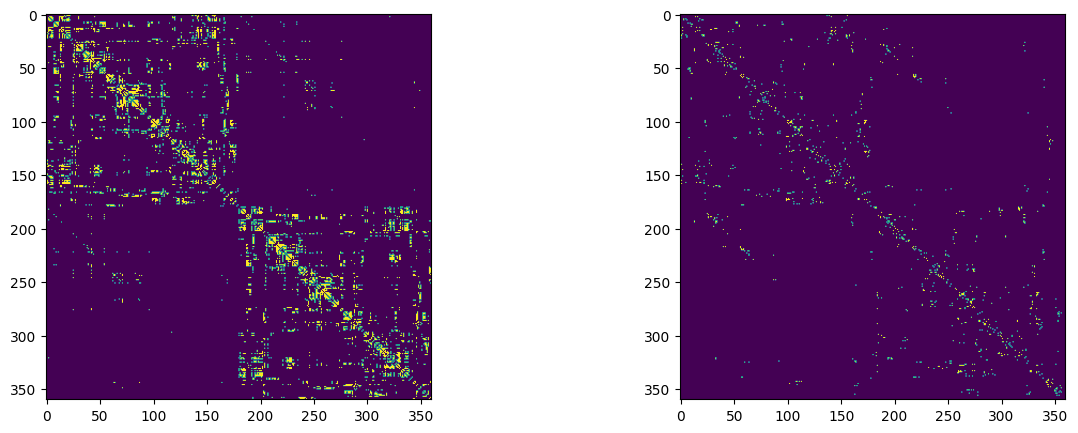

In [116]:
cadj = load("./resources/braingraph_viz/glasser_structconn.pkl")

# binarize at 5% left
thresh = np.quantile(cadj.flatten(), 0.95)
cadj = (cadj > thresh).astype(float)

assym = np.zeros_like(cadj)
for ridx in range(len(cortexnodes)):
    for cidx in range(len(cortexnodes)):
        if ridx == cidx:
            continue
        pts1, pts2 = cortexnodes[ridx], cortexnodes[cidx]
        if np.linalg.norm(pts1 - pts2) > 20:
            continue
        if (pts1[2] < 35) and (pts1[2] > 10):
            if pts1[1] <= -40:
                assym[ridx, cidx] = float(pts1[1] <= pts2[1])
            else:
                assym[ridx, cidx] = float(pts1[1] >= pts2[1])
        else:
            assym[ridx, cidx] = float(pts1[1] <= pts2[1])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(cadj)
ax[1].imshow(assym)

N = cadj.shape[0]

# zerodeg = np.where(np.sum(assym, axis=1) == 0)[0]
# for k in range(len(zerodeg)):
#     tmp = deepcopy(assym[zerodeg[k]])
#     tmp[zerodeg[k]-1] = 1.0
#     assym[zerodeg[k]] = tmp

# assym = diagonalize(assym).astype(float)

# zerodeg = np.where(np.sum(assym,axis=0) == 0)[0]
# for k in range(len(zerodeg)):
#     tmp = deepcopy(assym[:,zerodeg[k]])
#     tmp[zerodeg[k]-1] = 1.0
#     assym[:,zerodeg[k]] = tmp

# newassym = diagonalize(newassym)
# cadj = diagonalize(cadj)

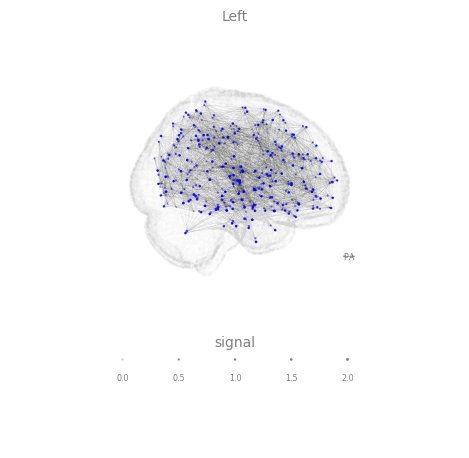

In [117]:
fig, ax = visualize_braingraph(
    np.linspace(0, 1, N), cadj, cortexnodes, figsize=(5, 5), nscale=1, axview=(0, 0)
)

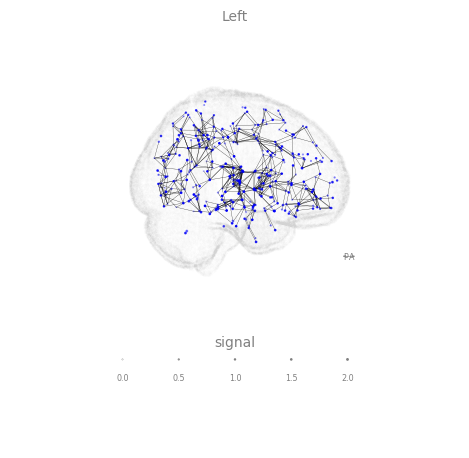

In [118]:
fig, ax = visualize_braingraph(
    np.linspace(0, 1, N),
    assym * 10,
    cortexnodes,
    figsize=(5, 5),
    nscale=1,
    axview=(0, 0),
)

The few operations implemented that we want to visualize are:
- Slepians (so energy concentration)
- Weighted edges
- Hilbert Transform
- Randomized
- Filtering
- Diffusion

In [119]:
L = compute_directed_laplacian(assym)

Lap = compute_directed_laplacian(cadj)
Uc, Vc = compute_basis(Lap)

Method chosen is: eig


In [73]:
# weighted = deepcopy(cadj)
# scaleedge = np.where((cortexnodes[:,1] < -55))[0]
# for k in scaleedge:
#     weighted[k] *= 3
#     weighted[:,k] *= 3

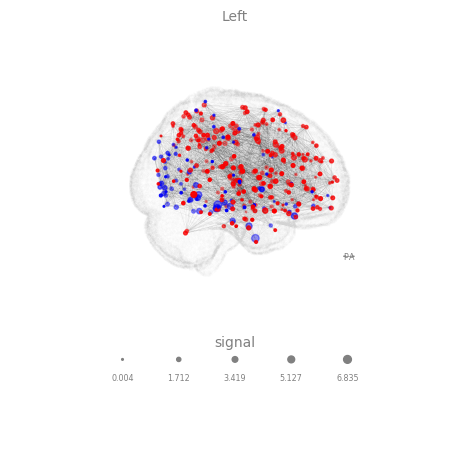

In [117]:
np.random.seed(99)
filtersig = np.concatenate(
    [[1], np.repeat(np.linspace(0, 1, Uc.shape[0] // 2 - 1)[::-1] ** 20, 2), [0]]
)
random_signal = np.random.random(Uc.shape[0])
random_signal = inverseGFT(random_signal, Uc)

plot_spectrum_gft(
    [random_signal, inverseGFT(filtersig, Uc)],
    Uc,
    Vc,
    ["original signal", "filter function"],
)

filtered_signal = inverseGFT(GFT(random_signal, Uc) * filtersig, Uc)
fig, ax = visualize_braingraph(
    filtered_signal, cadj, cortexnodes, figsize=(5, 5), nscale=30, axview=(0, 0)
)
fig, ax = visualize_braingraph(
    -random_signal, cadj, cortexnodes, figsize=(5, 5), nscale=30, axview=(0, 0)
)

In [120]:
initial_signal = np.zeros((N))
initial_signal[np.argmin(cortexnodes[:, 1])] = -100
diffused_signals = [initial_signal]

# Deg = (1/np.sum(assym, axis=1))
# Deg[Deg == np.inf] = 1.0
# assym_norm = np.diag(Deg) @ assym

for _ in range(99):
    initial_signal = initial_signal - 0.05 * initial_signal @ L
    diffused_signals.append(initial_signal)

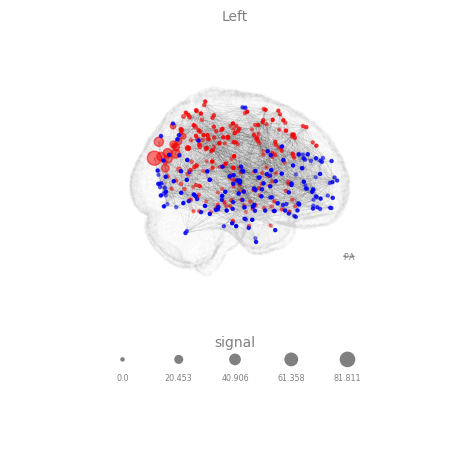

In [122]:
fig, ax = visualize_braingraph(
    diffused_signals[10],
    cadj,
    cortexnodes,
    figsize=(5, 5),
    nscale=np.abs(diffused_signals[k]).max(),
)

MoviePy - Building file test.gif with imageio.


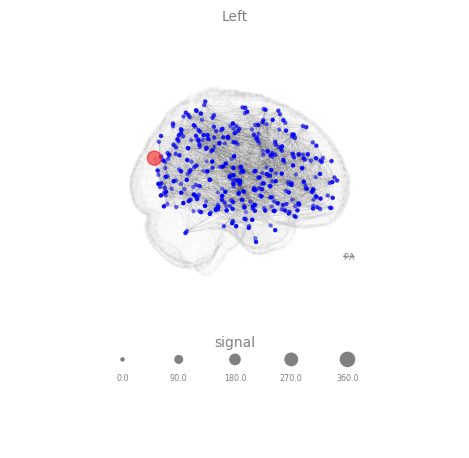

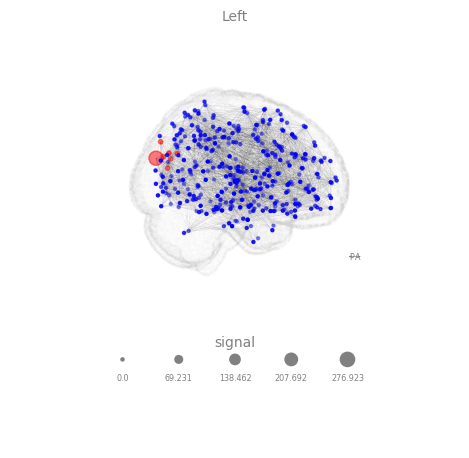

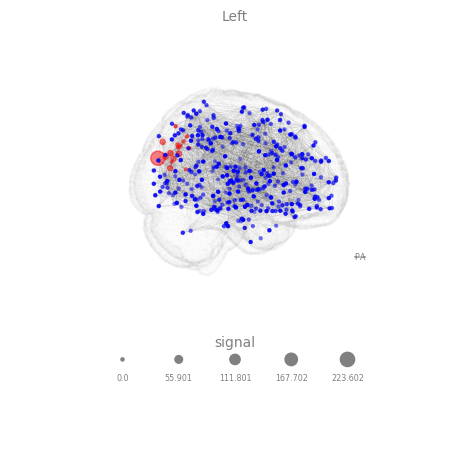

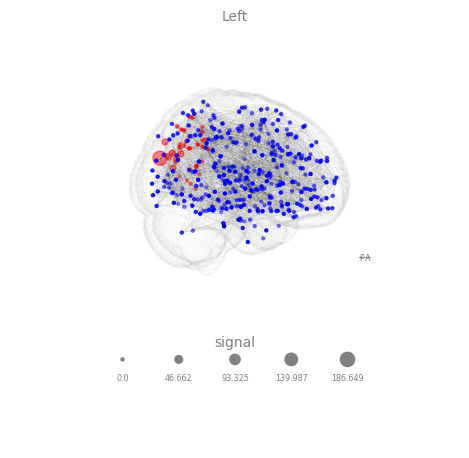

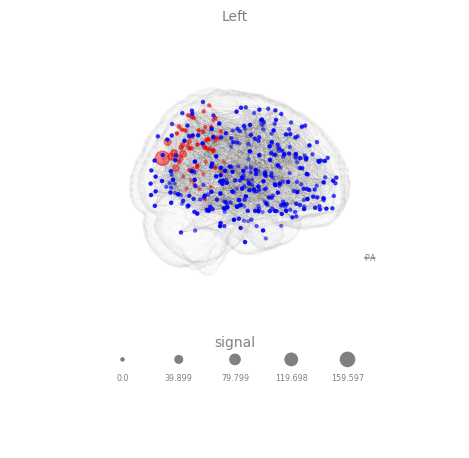

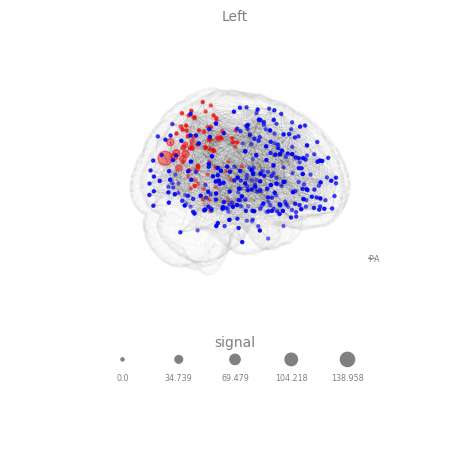

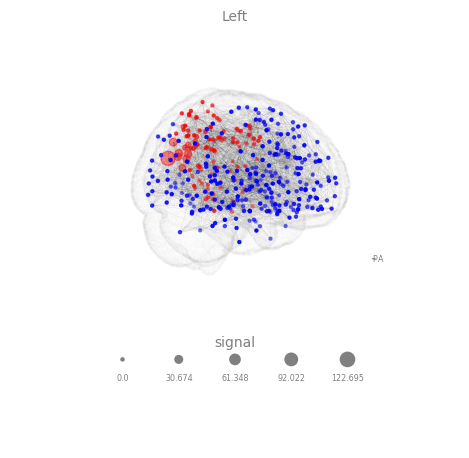

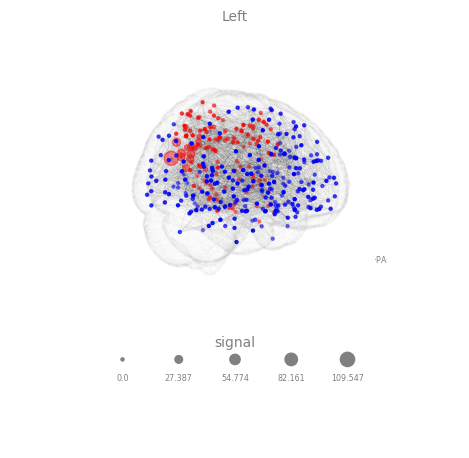

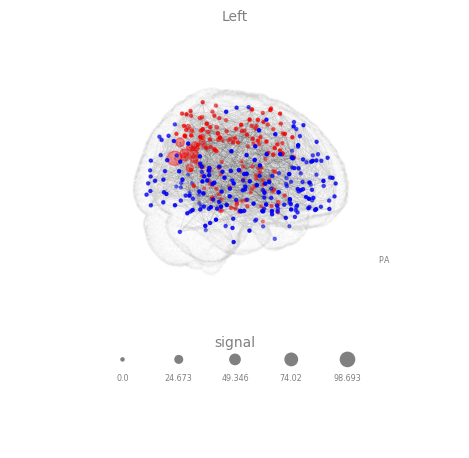

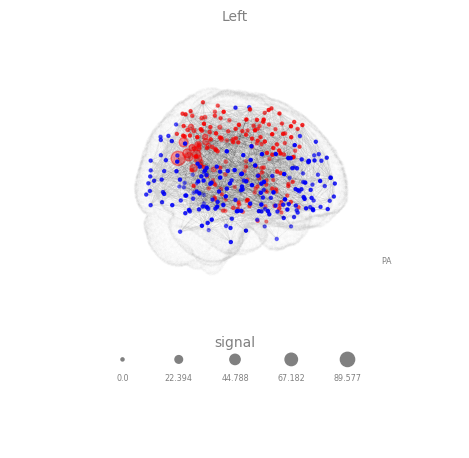

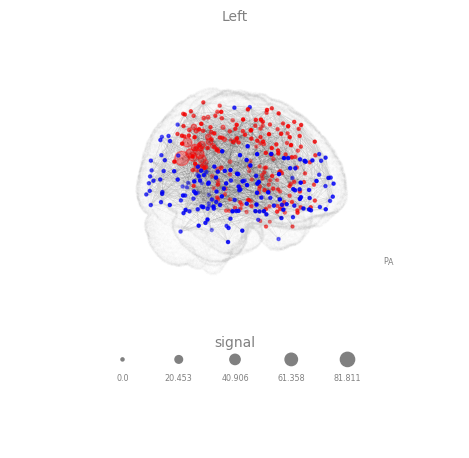

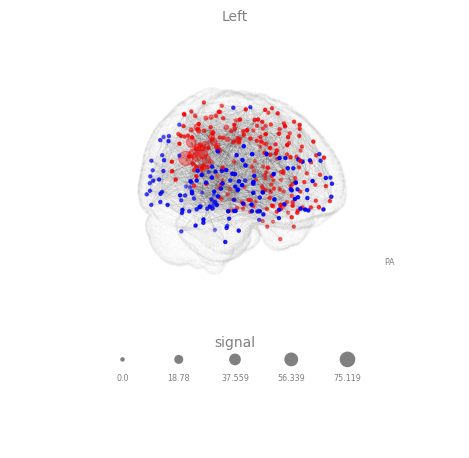

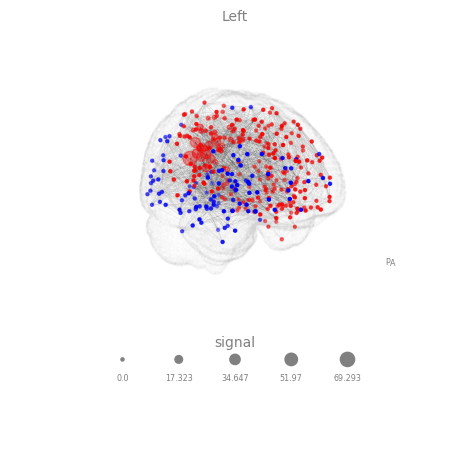

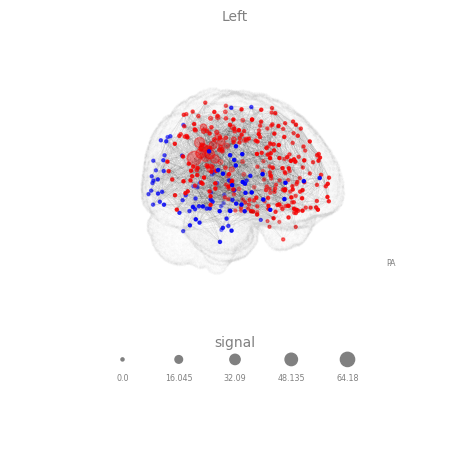

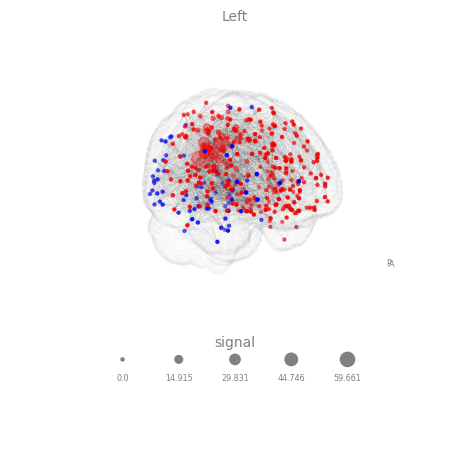

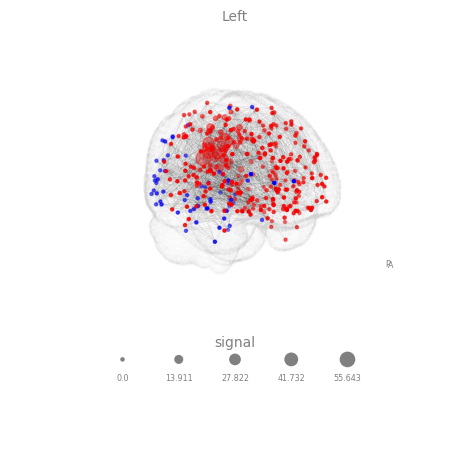

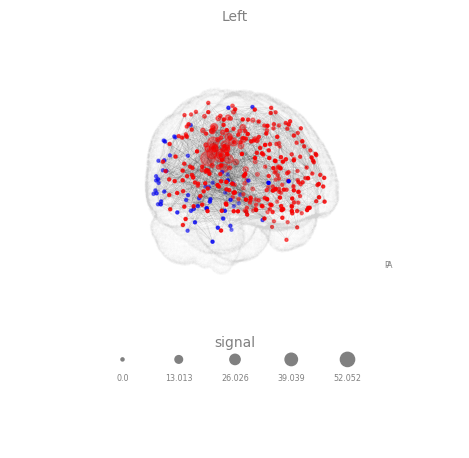

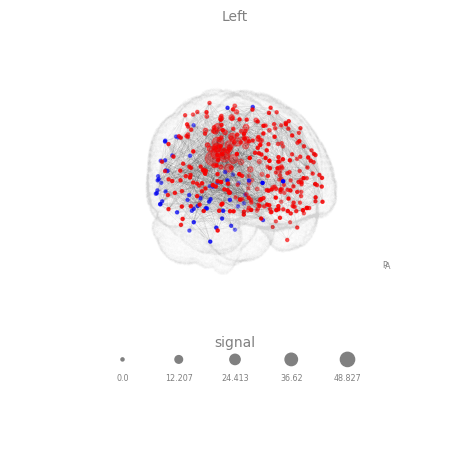

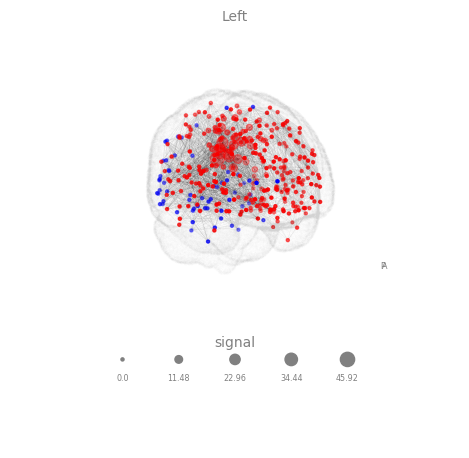

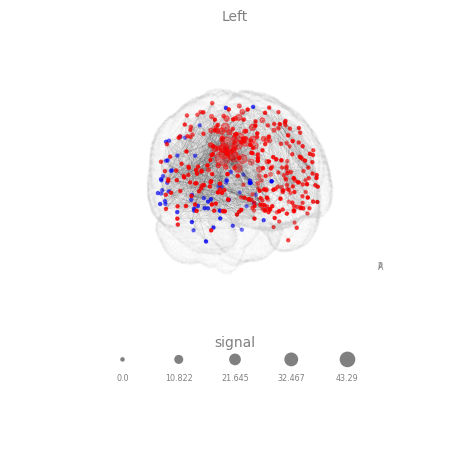

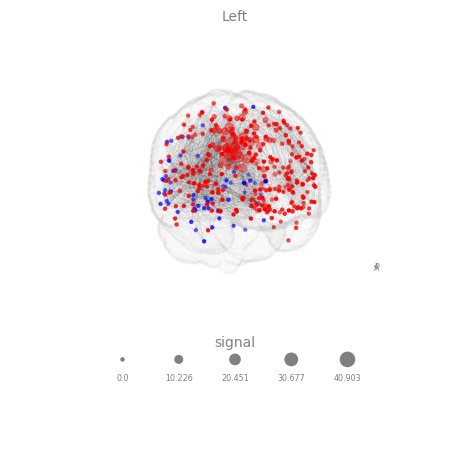

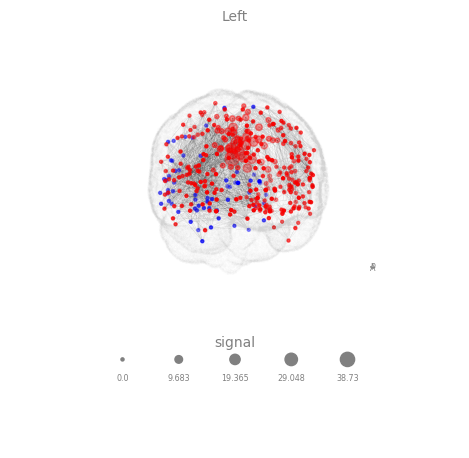

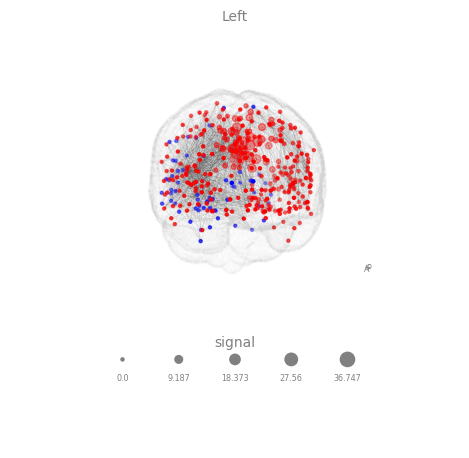

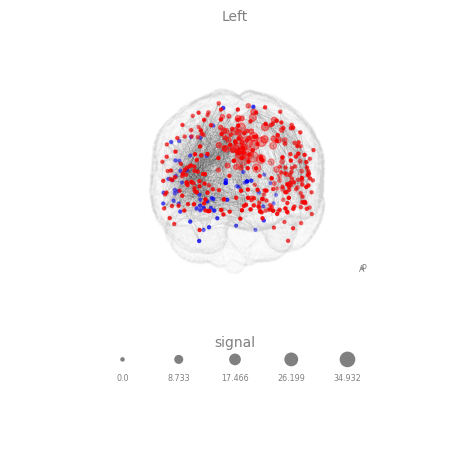

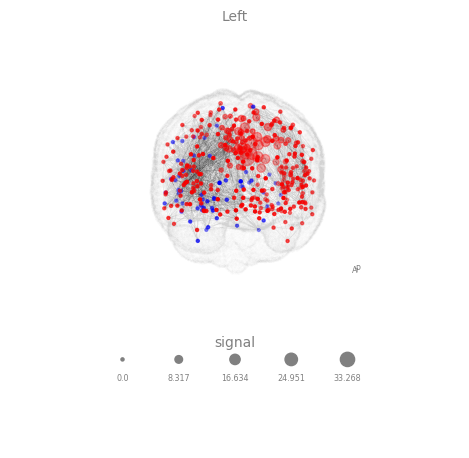

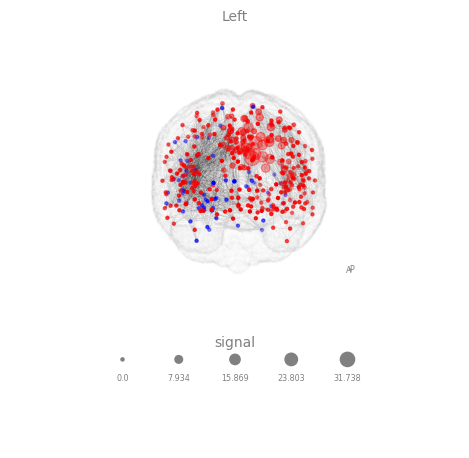

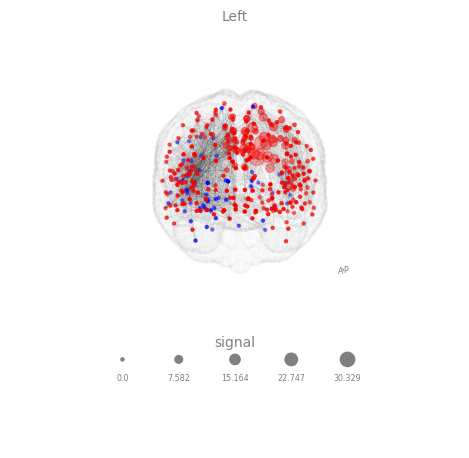

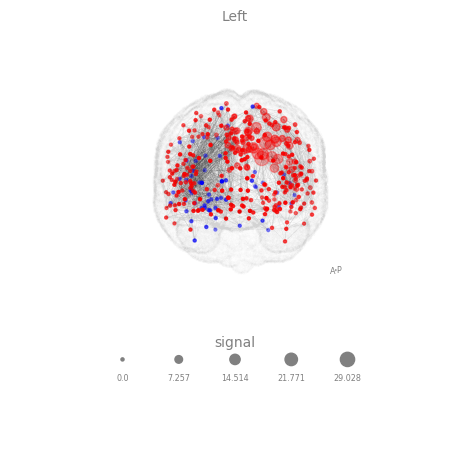

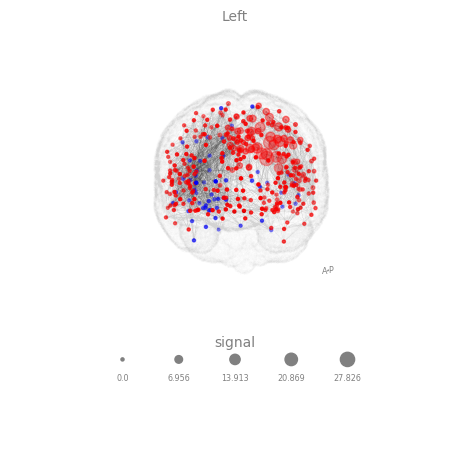

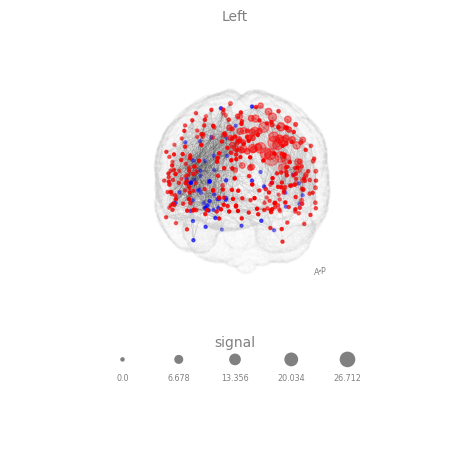

In [123]:
nbframes = 30
ang = np.linspace(0, 100, nbframes)
for k in range(nbframes):
    fig, ax = visualize_braingraph(
        diffused_signals[k],
        cadj,
        cortexnodes,
        figsize=(5, 5),
        nscale=np.abs(diffused_signals[k]).max(),
    )
    ax.view_init(elev=0, azim=ang[k])
    fig.savefig(f"/tmp/tmp{k}.png")

images = []
for k in range(nbframes):
    images.append(cv2.imread(f"/tmp/tmp{k}.png"))

clip = ImageSequenceClip(list(images), fps=10)
clip.write_gif("test.gif", fps=10)

In [124]:
images = []
for k in range(nbframes):
    images.append(cv2.imread(f"/tmp/tmp{k}.png")[:, :, ::-1])

clip = ImageSequenceClip(list(np.repeat(np.array(images), 100, axis=0)), fps=10)
clip.write_gif("test.gif", fps=10)

MoviePy - Building file test.gif with imageio.


In [ ]:
fig, ax = visualize_braingraph([], cadj, cortexnodes, figsize=(5, 5), nscale=200)

Takeways: 
- When looking at complex eigenmodes of connectivity real values are likely to be more matching the patterns we expect. Imaginary values are not seemingly representative and finally magnitude does sometimes to simlarly as real values.
- It is difficult to make undiagonalizable larger structural connectomes such as Schaeffer 400. 